<img src="https://www.gov.br/cbpf/pt-br/assuntos/noticias/titular-tem-artigo-em-periodico-de-prestigio/cbpf.png"  width="500" />



# Tutorial - Classificador de Espectros de Supernovas usando Rede Neural Recorrente (RNN)

Vamos dar uma breve introdução de como utilizar uma rede neural recorrente para realização de uma classificação binária de espectros de supernovas em tipo I and tipo II.
### Instalação:
Para usar esse notebook importe/instale as seguintes bibliotecas:
- Tensorflow
- NumPy
- Matplotlib
- sklearn
- seaborn

### Informações sobre o dataset: 
- Os espectros são numpy arrays de shape (550,1). Onde os 550 valores seriam o fluxo no intervalo de comprimento de onda de (5000 - 8000) Angstrom
- O fluxo está em unidade de erg/s/cm^2/Å e corrigido para 10 parsec (Antes da normalização).
- Os dados dos espectros de supernovas já foram preprocesssados e normalizados.

   

    - email: phelipedarc@gmail.com

In [56]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import numpy
import matplotlib.pyplot as plt
import time
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential , Model, load_model
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D, Input,LeakyReLU,GlobalMaxPooling2D
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.metrics import AUC
import h5py
import scipy

### Funções a serem utilizadas para avaliação do modelo:

In [3]:
def plot_metrics(X_1,y_1,classificador1,history,losse = 1):
    
    '''
    input:
    
    -<array>- y_1 = List of the real label
    
    -<array>- X_1 = Images
    
    -<model>- classificador1 = model already trained


    Output:
    
    Displays the two main plots in a Binary Classification:
    
    
    1) The Roc Curve: Summarize the trade-off between the true positive rate and false positive rate for a predictive model using 
    different probability thresholds.
    ideally whe would like to have 1.0 of true positive rate and 0.0 of False negative rate.
    
    The AUC(area under the curve) simplifies the plot in a single number, 
    if the neural network misclassified all the data, the AUC is zero, and if the NN classifies all the images correctly the AUC is 1.0 (one).

    
    2) Precision-Recall Curve: Summarize the trade-off between the true positive rate and 
    the positive predictive value for a predictive model using different probability thresholds.
    
    
    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
    fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

    The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.
    The recall is intuitively the ability of the classifier to find all the positive samples.
    
    
    '''
    y_predict = classificador1.predict(X_1)
    y_actu = y_1
    #----------Loss curve------------------------------------------------------------------------------------------------------
    if losse == 1:
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.plot(np.argmin(history.history['val_loss']), np.min(history.history['val_loss']), marker="x", color="r", label="best model")
        plt.title('model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    

    #--------- ROC Curve -------------------------------------------------------------------------------------------------------
    from sklearn.metrics import roc_curve
    #corte mais proximo do ponto 0 - 1 e pegar o corte correspondente
    y_pred_keras = classificador1.predict(X_1).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve( y_actu, y_pred_keras)
    from sklearn.metrics import auc
    i = np.arange(len(tpr_keras)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr_keras-(1-fpr_keras), index=i), 'threshold' : pd.Series(thresholds_keras, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    #print(list(roc_t['threshold']))
    
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(figsize = (6,5),dpi=100)
    plt.plot([0.0,0.0,1.0], [0.0,1.0,1.0], label='Perfect Performance (AUC = 1.0)', ls=':', zorder=10, lw=1.0,c='Green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    #plt.plot(np.argmin(history.history['val_loss']), np.min(history.history['val_loss']), marker="x", color="r", label="Threshold")
    
    plt.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show() 
    #-------------- Precision-Recall Curve -----------------------------------------------------------------------------------
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    plt.figure(figsize = (6,5),dpi=100)
    precision, recall, thresholds = precision_recall_curve(y_actu,y_predict)
    lr_precision, lr_recall, _ = precision_recall_curve(y_actu,y_predict)

    aucski = auc(recall, precision)
    no_skill = len(y_actu[y_actu==1]) / len(y_actu)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier (area = {:.2f})'.format(aucski))
    # axis labels
    plt.title('Precision x Recall curve')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    
    #------------------------------------------------------------------------------

In [65]:
def matrix_confu(y_actua,y_preda):
    '''
    **Create a Confusion Matrix basead in 
    a Binary Classification**
    
    -<array>- y_actua = List of the real classification
    
    -<array>- y_preda = List of the values predited by the model
    
    Output: Confusion Matrix and Binary classification metrics
    
    Metrics:
    
    - Precision: tp / (tp + fp)
    The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    
    - Recall: tp / (tp + fn)
    The recall is intuitively the ability of the classifier to find all the positive samples.
    
    - F1-score: 2* (Precision * Recall) / (Precision + Recall)
    The goal of the F1 score is to combine the precision and recall metrics into a single metric.

    - Accuracy: (tp + tn) / (tp + fn + fp+ tn)
    The Accuracy is the percentage of correct labels with respect to the total
    
    
    
    
    '''
    import seaborn as sns
    df_confusion = np.array(pd.crosstab(y_actua, y_preda, rownames=['Real'], colnames=['predicted']),dtype=np.float64)
    df_confusion_percent = np.zeros((2,2))
    y_actua = pd.DataFrame(y_actua)
    y_preda = pd.DataFrame(y_preda)
    df_confusion_percent[0,0]=df_confusion[0][0]/y_actua.value_counts()[0]
    df_confusion_percent[0,1]=df_confusion[0][1]/y_actua.value_counts()[0]
    df_confusion_percent[1,0]=df_confusion[1][0]/y_actua.value_counts()[1]
    df_confusion_percent[1,1]=df_confusion[1][1]/y_actua.value_counts()[1]
    x_axis_label=['Real SNII','Real SNI',]
    y_axis_label=['Predicted SNII ','Predicted SNI ']
    tn1 = round(np.float64((df_confusion[0][0]/(df_confusion[0][0]+df_confusion[0][1]))), 3)

    tp1 = round(np.float64((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0])), 3)

    fn1 = round(np.float64(df_confusion[1][0]/(df_confusion[1][0]+df_confusion[1][1])), 3)

    fp1 = round(np.float64(df_confusion[0][1]/(df_confusion[0][1]+df_confusion[0][0])), 3)
       #----------------------------------------------------------------------------------------------------------------------

    
    acuracia = ((df_confusion[1][1]+df_confusion[0][0])/(df_confusion[1][1]+df_confusion[0][0]+df_confusion[1][0]+df_confusion[0][1]))*100
    precisao=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[0][1]))*100
    recall=float((df_confusion[1][1])/(df_confusion[1][1]+df_confusion[1][0]))*100

    f1= 2*(precisao*recall)/(precisao+recall) 
   
    from sklearn.metrics import f1_score   



    porcentagens = [str(int(tn1*100000)/1000)+'%',str(int(fn1*100000)/1000)+'%',str(int(fp1*100000)/1000)+'%',str(int(tp1*100000)/1000)+'%']
    entradas = [int(df_confusion[0,0]),int(df_confusion[1,0]),int(df_confusion[0,1]),int(df_confusion[1,1])]
    labels = [f'{numero} \n{porc}' for numero, porc in zip(entradas,porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,5),dpi=110)
    sns.heatmap(df_confusion_percent,square=True,
                 cmap="BuGn", annot=labels, cbar=False,fmt='',xticklabels=x_axis_label, yticklabels=y_axis_label,linewidths=1.6, linecolor='black', annot_kws={'fontsize':16,'fontfamily':'serif'})

    plt.text(2.2, 1, 'Recall: '+ str(np.round(recall,2))+'%'+'\n'+'Precision:'+ str(np.round(precisao,2))+'%'+'\n'+ 'F1-score:'+ str(np.round(f1,2))+'%'+'\n'+'Accuracy:'+str(np.round(acuracia,2))+'%', fontsize =15,
             fontfamily='serif', 
             bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
    plt.show()


# Importando o Dataset

In [82]:
X_datasn = np.load('/tf/dados10Tdock/phelipedata/KilonovasDataset/NEWNEWSN1preprocessed.npy',allow_pickle=True)
X_datasn2 = np.load('/tf/dados10Tdock/phelipedata/KilonovasDataset/NEWNEWSN2preprocessed.npy',allow_pickle=True)
#criando os labels -- SNI (label 1) e SNII (label 0)
y_data1 = np.ones((len(X_datasn),1))
y_data2 = np.zeros((len(X_datasn2),1))
y_data = np.concatenate((y_data1,y_data2),axis=0)
#Selecionando somente a componente referent ao Fluxo normalizado
X_data= np.concatenate((X_datasn[:,:,1:2],X_datasn2[:,:,1:2]),axis=0)

In [83]:
print("Dataset inteiro:",len(X_data),'  Numero de Supernovas tipo I:',len(X_datasn),'  Numero de Supernovas tipo II:',len(X_datasn2))

Dataset inteiro: 4736   Numero de Supernovas tipo I: 3119   Numero de Supernovas tipo II: 1617


In [84]:
#Separando em treino/validação/teste
from sklearn.model_selection import train_test_split
X_train, X_t, y_train, y_t = train_test_split(X_data, y_data, test_size=0.2, random_state=69)
X_test, X_valid, y_test, y_valid = train_test_split(X_t, y_t, test_size=0.5, random_state=69)

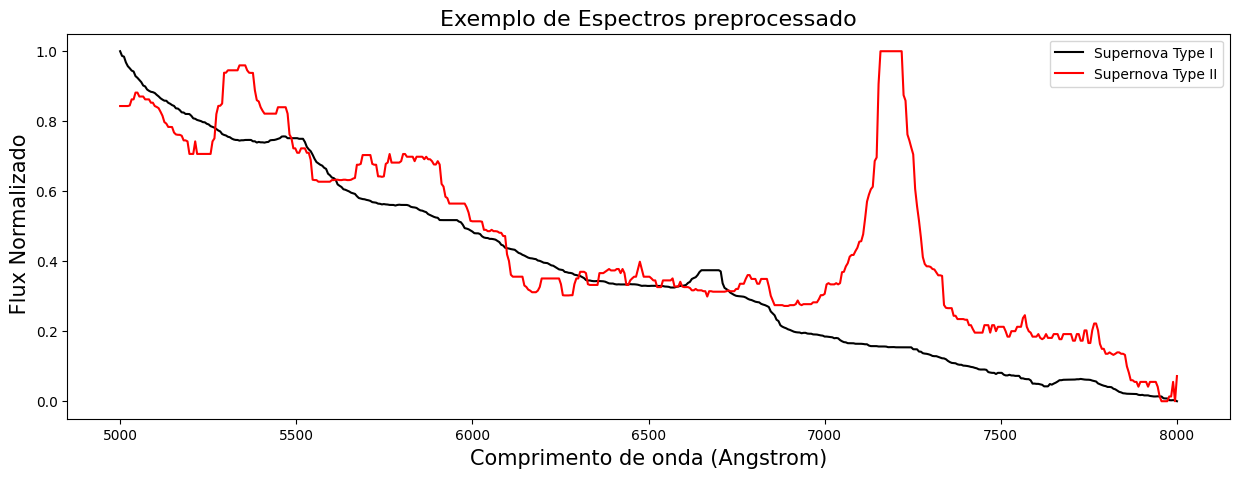

In [86]:
plt.figure(dpi=100, figsize=(15,5))
plt.plot(X_datasn[5][:,0],X_datasn[5][:,1], 'k',label='Supernova Type I')
#plt.plot(X_datasn[60][:,0],scipy.ndimage.uniform_filter1d(X_datasn[60][:,1],5), 'k.', label='Smooth - Supernova Type I')
plt.xlabel('Comprimento de onda (Angstrom)', fontsize=15)
plt.ylabel(' Flux Normalizado', fontsize=15)
plt.plot(X_datasn2[40][:,0],X_datasn2[40][:,1], 'r', label='Supernova Type II')
#plt.plot(X_datasn2[0][:,0],scipy.ndimage.gaussian_filter1d(X_datasn2[60][:,1],40), 'r.', label='Smooth - Supernova Type II')
plt.title('Exemplo de Espectros preprocessados', fontsize=16)
plt.legend()
plt.show()

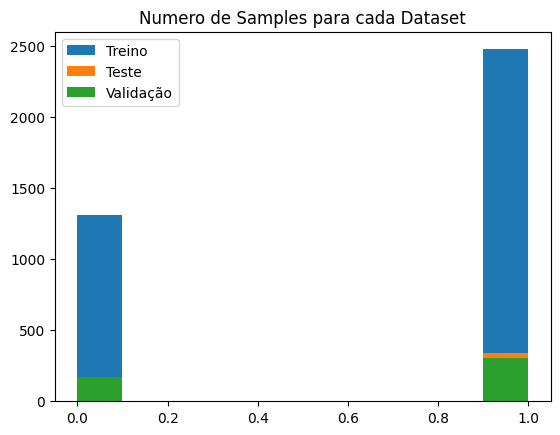

In [87]:
plt.hist(y_train,label = 'Treino')
plt.hist(y_test,label = 'Teste')
plt.hist(y_valid,label = 'Validação')
plt.title('Numero de Samples para cada Dataset')
plt.legend()
plt.show()

# Introdução à RNN:
Uma rede neural recorrente (RNN, do inglês Recurrent Neural Network) é uma generalização da rede neural tradicional mas que tem uma "memória" interna, projetado para lidar com sequências de dados, como texto, áudio ou séries temporais/espectros. Diferente das redes neurais tradicionais, que processam cada entrada de forma independente, as RNNs possuem conexões de retroalimentação (recorrentes) que lhes permitem manter uma memória interna e processar informações sequenciais. 

A estrutura principal de uma RNN consiste em unidades recorrentes, também conhecidas como células, que são repetidas em uma sequência temporal. Cada unidade recorrente recebe uma entrada e produz uma saída, além de manter um estado oculto (ou estado de memória) que é passado adiante para a próxima unidade. Essa retroalimentação permite que a RNN tome decisões com base em informações anteriores.


No entanto, as RNNs básicas possuem uma limitação conhecida como "desaparecimento/morte do gradiente" (vanishing gradient), que ocorre quando a influência de informações anteriores diminui rapidamente à medida que avançamos na rede, tornando difícil para a rede aprender dependências de longo prazo. Para mitigar esse problema, foram desenvolvidas variantes das RNNs, como as redes neurais recorrentes de longa memória **(Long Short-Term Memory ou LSTM)** 

## Redes de Memória de Curto Prazo Longo (LSTM)
Redes de Memória de Curto Prazo Longo — geralmente chamadas apenas de “LSTMs” — são um tipo especial de RNN, capaz de aprender dependências de longo prazo. Eles foram introduzidos por Hochreiter & Schmidhuber (1997)

Uma LSTM possui unidades de memória chamadas "células" que são conectadas em uma estrutura recorrente. Cada célula possui três portões principais: o portão de esquecimento (forget gate), o portão de entrada (input gate) e o portão de saída (output gate).

- O portão de esquecimento decide quais informações antigas devem ser descartadas da célula de memória. Ele analisa a entrada atual e a entrada anterior e produz um valor entre 0 e 1 para cada elemento da memória, determinando quanto de informação deve ser esquecida.

- O portão de entrada controla a adição de novas informações na célula de memória. Ele determina quais valores de entrada devem ser atualizados e em que medida. O portão de entrada também varia de 0 a 1 para cada elemento da memória.

- O portão de saída regula a saída da célula de memória. Ele determina quais partes da memória serão transmitidas para a saída com base nas entradas atuais e na memória atualizada.

Esses portões permitem que a LSTM controle a informação que é lembrada, esquecida e atualizada, proporcionando uma memória de longo prazo mais efetiva. Em cada passo de tempo, a LSTM recebe uma entrada, atualiza sua memória e gera uma saída. A informação é propagada ao longo da sequência, permitindo que a LSTM aprenda dependências temporais de longo alcance.


## Treinamento:
 

Para criarmos um classificador binário que recebe de input a SED de supernova temos que ficar atento a construção da arquitetura da rede, neste caso optamos por uma camada convolucional, que tem como objetivo realizar uma *feature extraction* das SEDs e faciliatar o processo de aprendizado da rede. Em seguida adicionamos 4 camadas de *LSTMs*, capaz de aprender dependências de longo prazo.

In [79]:
#Criando a arquitetura da rede:
model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(550, 1)),
                                    #--------------Feature extraction -----------------------------------------------------------
                                    tf.keras.layers.Conv1D(filters=512, activation = tf.keras.activations.selu,kernel_size=3),
                                    tf.keras.layers.Conv1D(filters=256, activation = tf.keras.activations.selu,kernel_size=2),
                                    tf.keras.layers.MaxPooling1D(strides = 5 , pool_size = 5),
                                    tf.keras.layers.Conv1D(filters=128, activation = tf.keras.activations.selu,kernel_size=2),
                                    tf.keras.layers.Conv1D(filters=64, activation = tf.keras.activations.selu,kernel_size=2),
                                    tf.keras.layers.MaxPooling1D(),
                                    #--------------Rede Neural Recorrente - LSTM -----------------------------------------------------------
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1200, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(400, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
                                    tf.keras.layers.GlobalMaxPooling1D(),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(100, activation='relu'),
                                    tf.keras.layers.Dense(40, activation='relu'),
                                    #--------------Ultima Camada para classificação binária -----------------------------------------------------------
                                    tf.keras.layers.Dense(1,activation='sigmoid')])


#Compilando o modelo com o Optimizador NAdam e Função custo "Binary cross entropy" (BCE) por se tratar de uma classificação binaria
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy','Precision'])
# O parametro "class weights" nos permite designiar differentes pesos para as diferentes classes durante o treinamnto
# Dando um peso de 1.44 para a classe 0 e 0.76 para a classe 1, o modelo dá mais importancia para a classe em minoria assim aumentando a taxa de verdadeiros negativo (True negative rate).
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y = pd.DataFrame(y_train))
class_weights = dict(zip(np.unique(y_train[:,0]), class_weights))
class_weights

{0.0: 1.4458015267175572, 1.0: 0.7643260694108152}

In [81]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',patience=25,min_delta=0.01, restore_best_weights=True)
history=model.fit(X_train, y_train,validation_data= (X_valid,y_valid),batch_size=512, epochs=200,callbacks=[es],class_weight=class_weights,verbose=1)

Epoch 1/200


KeyboardInterrupt: 

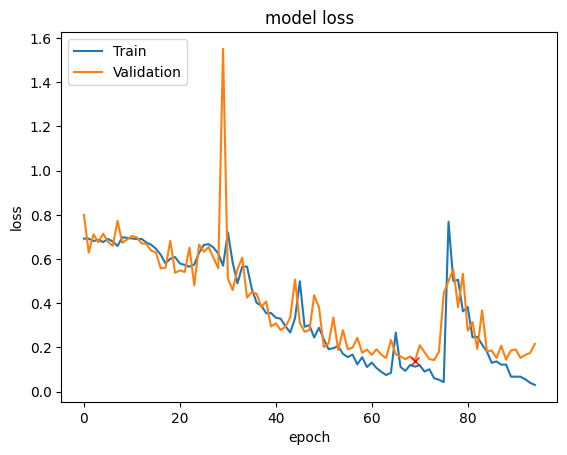

[0.6565160155296326]


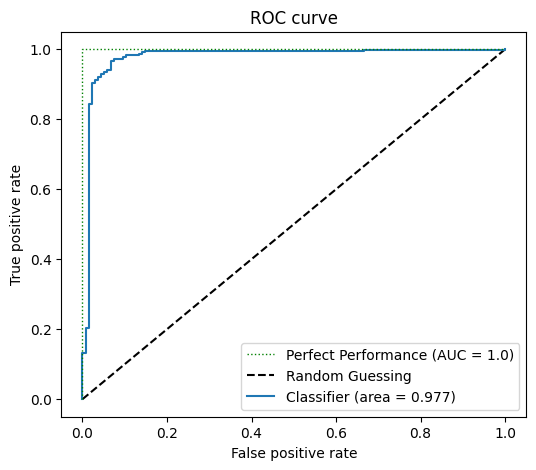

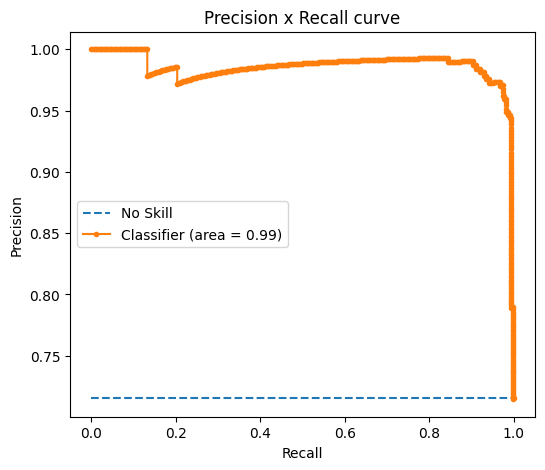

In [72]:
plot_metrics(X_test,y_test,model,history,losse = 1)

### Avaliação do modelo no Dataset de teste

In [73]:
y_pred= model.predict(X_test[:,:,1:2])
#Defina um treshold, neste caso utilizaremos o threshold de 0.5.
t = 0.5

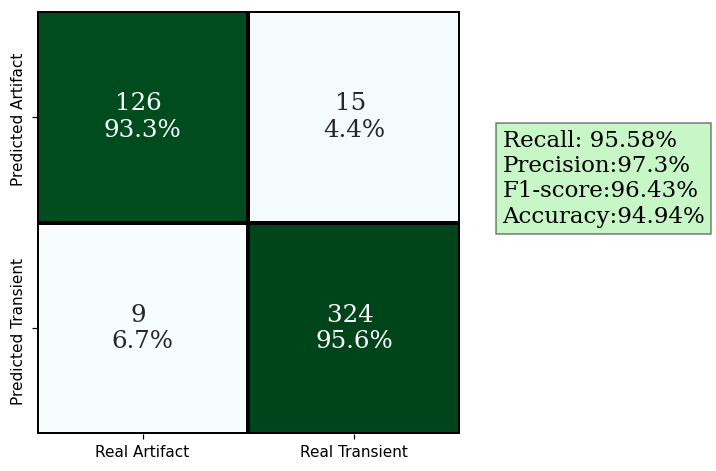

In [76]:
matrix_confu(y_test[:,0],(y_pred[:,0]>t)*1)